# Danh sách thành viên:

| MSSV|Họ và tên|
| ----------- | ----------- |
|20133029|Nguyễn Trí Dũng|
|20133090|Nguyễn Khoa Quang Thắng|
|20133xxx|Văn Mai Thanh Nhật|
|20133xxx|Huỳnh Minh Phước|

# Khai phá dữ liệu giao dịch của Website bán hàng

# Thư viện sử dụng

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from itertools import repeat
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
from os.path import exists

# Thông tin tập dữ liệu

Link của tập dữ liệu: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business?select=Sales+Transaction+v.4a.csv

Tác giả: Gabriel Ramos

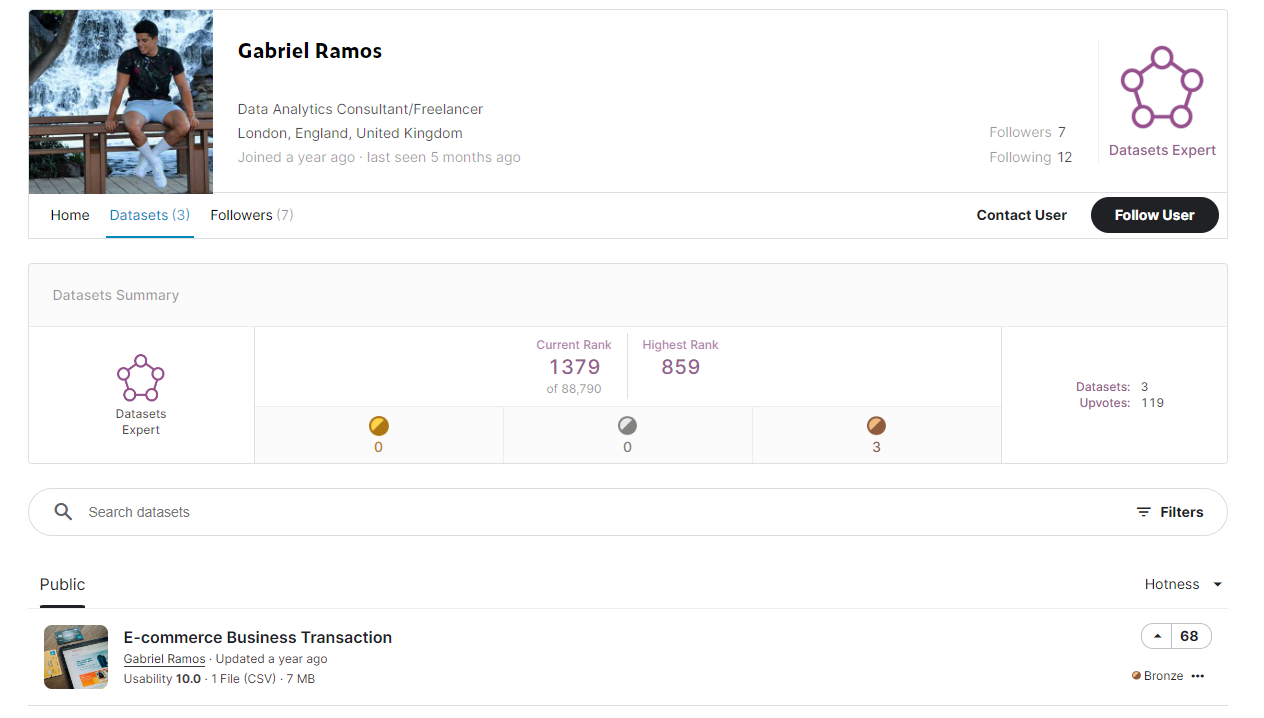

This is a sales transaction data set of UK-based e-commerce (online retail) for one year. This London-based shop has been selling gifts and homewares for adults and children through the website since 2007. Their customers come from all over the world and usually make direct purchases for themselves. There are also small businesses that buy in bulk and sell to other customers through retail outlet channels.

In [2]:
data = pd.read_csv("SalesTransaction.csv")

In [3]:
#data = data.head(10000)

Các attribute của tập dữ liệu:


The data set contains 500K rows and 8 columns. The following is the description of each column.

1. **TransactionNo (categorical):** a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.

2. **Date (numeric):** the date when each transaction was generated.

3. **ProductNo (categorical):** a five or six-digit unique character used to identify a specific product.

4. **Product (categorical):** product/item name.

5. **Price (numeric):** the price of each product per unit in pound sterling (£).

6. **Quantity (numeric):** the quantity of each product per transaction. Negative values related to cancelled transactions.

7. **CustomerNo (categorical):** a five-digit unique number that defines each customer.

8. **Country (categorical):** name of the country where the customer resides.

There is a small percentage of order cancellation in the data set. Most of these cancellations were due to out-of-stock conditions on some 
products. Under this situation, customers tend to cancel an order as they want all products delivered all at once.


# Làm sạch dữ liệu:

## Xem 5 dòng đầu của tập dữ liệu:

In [4]:
data.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


## Xem thông tin của tập dữ liệu:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


## Kiểm tra có dòng nào bị thiếu dữ liệu:

Có tổng cộng 55 dòng bị thiếu mất CustomerNo, nên ta sẽ xử lí 55 dòng bằng cách loại bỏ

In [6]:
data.isnull().sum()

TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
dtype: int64

In [7]:
data.dropna(inplace=True)

##

In [8]:
data["CustomerNo"] = data["CustomerNo"].astype(str)
data["Date"] = pd.DatetimeIndex(data["Date"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536295 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  536295 non-null  object        
 1   Date           536295 non-null  datetime64[ns]
 2   ProductNo      536295 non-null  object        
 3   ProductName    536295 non-null  object        
 4   Price          536295 non-null  float64       
 5   Quantity       536295 non-null  int64         
 6   CustomerNo     536295 non-null  object        
 7   Country        536295 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.8+ MB


# EDA

In [9]:
data["TotalPrice"] = data['Price']*data['Quantity']

In [10]:
year_2019 = data.loc[data['Date'].dt.year == 2019]
year_2018 = data.loc[data['Date'].dt.year == 2018]

# Số lượng của transaction bị huỷ

Lọc những transaction bị huỷ và không bị huỷ

In [11]:
data_Without_CancelTransaction = data.loc[~(data['Quantity']<0)]
data_Without_CancelTransaction.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalPrice
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64


In [12]:
data_CancelTransaction = data.loc[data['Quantity']<0]
data_CancelTransaction.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalPrice
1616,C581484,2019-12-09,23843,Paper Craft Little Birdie,6.19,-80995,16446.0,United Kingdom,-501359.05
1617,C581490,2019-12-09,22178,Victorian Glass Hanging T-Light,6.19,-12,14397.0,United Kingdom,-74.28
1618,C581490,2019-12-09,23144,Zinc T-Light Holder Stars Small,6.04,-11,14397.0,United Kingdom,-66.44
1619,C581568,2019-12-09,21258,Victorian Sewing Box Large,6.19,-5,15311.0,United Kingdom,-30.95
1620,C581569,2019-12-09,84978,Hanging Heart Jar T-Light Holder,6.19,-1,17315.0,United Kingdom,-6.19


# Tìm các outlier khách hàng mua hàng số lượng nhiều

In [13]:
customer_quantity = []
for i in data_Without_CancelTransaction['CustomerNo'].unique():
    sum_Quantity = data_Without_CancelTransaction.loc[data_Without_CancelTransaction['CustomerNo'] == i].Quantity.sum()
    sum_Price = data_Without_CancelTransaction.loc[data_Without_CancelTransaction['CustomerNo'] == i].TotalPrice.sum()
    customer_quantity.append([i, sum_Quantity,sum_Price])
customer_quantity = pd.DataFrame(data=customer_quantity)
customer_quantity.columns = ["CustomerNo", "TotalQuantity","TotalPrice"]

In [14]:
customer_quantity.head()

,CustomerNo,TotalQuantity,TotalPrice
0,17490.0,1134,13538.07
1,13069.0,5885,63353.94
2,12433.0,11062,115454.49
3,13426.0,2245,25893.59
4,17364.0,2701,30254.25


<Axes: xlabel='TotalQuantity'>

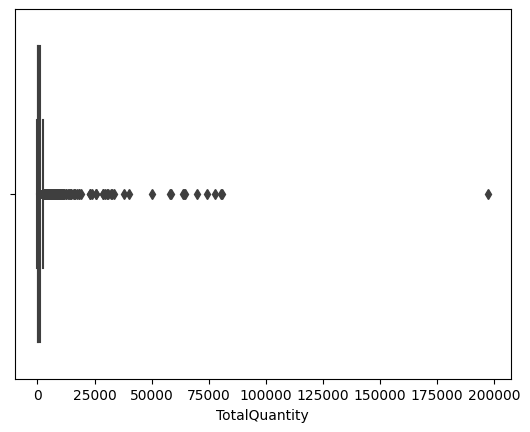

In [15]:
sb.boxplot(x='TotalQuantity',data=customer_quantity)

Tính Q1, Q3, IQR

In [16]:
Q1 = customer_quantity.TotalQuantity.quantile(0.25)
Q3 = customer_quantity.TotalQuantity.quantile(0.75)
IQR = Q3 - Q1
print("Q1: ",Q1)
print("Q3: ",Q3)
print("IQR: ",IQR)

Q1:  158.0
Q3:  1041.75
IQR:  883.75


Tìm outlier

In [17]:
customer_quantity_outlier = customer_quantity.loc[(customer_quantity["TotalQuantity"] < Q1-1.5*IQR) | (customer_quantity["TotalQuantity"] > Q3+1.5*IQR)].sort_values(by="TotalQuantity",ascending=False)
print("Tổng số outlier: ",len(customer_quantity_outlier))
customer_quantity_outlier.head(10)

Tổng số outlier:  409


,CustomerNo,TotalQuantity,TotalPrice
75,14646.0,197420,2112282.03
6,16446.0,80997,1002741.57
125,14911.0,80383,914633.52
1497,12415.0,77669,900545.54
4519,12346.0,74215,840113.80
613,17450.0,69993,891438.53
164,17511.0,64549,639006.19
25,18102.0,64124,897137.36
246,13694.0,63860,646116.78
608,14298.0,58343,636167.17


In [18]:
customer_quantity_without_outlier = customer_quantity[~customer_quantity.isin(customer_quantity_outlier)]
customer_quantity_without_outlier.dropna(inplace=True)


<Axes: xlabel='TotalQuantity'>

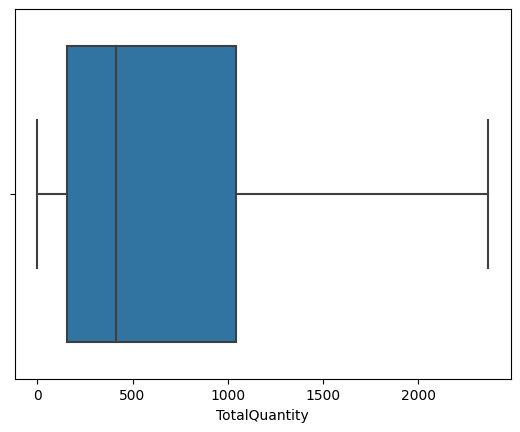

In [19]:
sb.boxplot(x='TotalQuantity',data=customer_quantity,showfliers = False)

# Thuật toán Gom cụm

c:\Users\Hi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

Text(0, 0.5, 'WCSS')

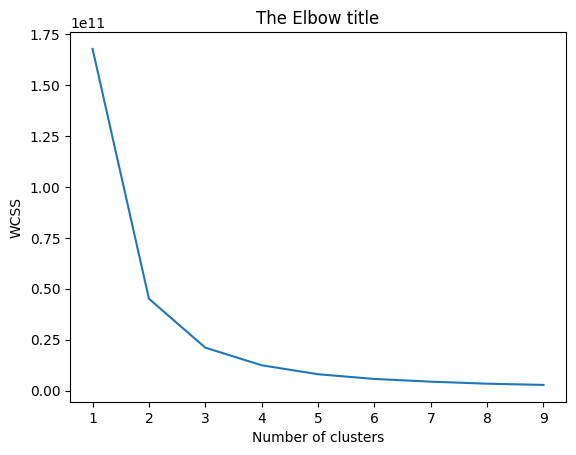

In [20]:
wcss=[] #is the sum of the squared distance between each point and the centroid in a cluster.
for i in range (1,10):
    kmeans = KMeans(i)
    kmeans.fit(customer_quantity_without_outlier.iloc[:,1:3])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [21]:
kmeans = KMeans(3)
kmeans.fit(customer_quantity_without_outlier.iloc[:,1:3])#Lấy 2 cột totalquantity và total price làm input
identified_clusters = kmeans.fit_predict(customer_quantity_without_outlier.iloc[:,1:3])
customer_quantity_without_outlier['Clusters'] = identified_clusters
customer_quantity_without_outlier.head()

c:\Users\Hi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerNo,TotalQuantity,TotalPrice,Clusters
0,17490.0,1134.0,13538.07,2
3,13426.0,2245.0,25893.59,1
5,14441.0,446.0,6326.48,2
8,17001.0,2164.0,21680.74,1
9,15694.0,1680.0,21902.34,1


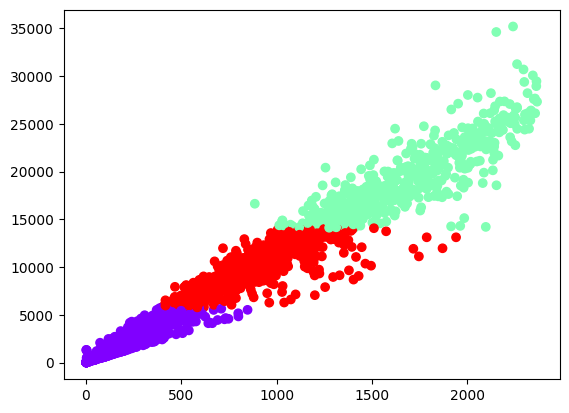

In [22]:
#Cần thêm xlab và ylab
plt.scatter(customer_quantity_without_outlier['TotalQuantity'],customer_quantity_without_outlier['TotalPrice'],c=customer_quantity_without_outlier['Clusters'],cmap='rainbow')

# Thuật toán FP-Growth

In [47]:
if not exists("./transactionEncoder.csv"):
    transactionFreq = []
    for i in data['TransactionNo'].unique():#Với mỗi transactionNo
        transactionFreqRow = []
        quantity = data[data['TransactionNo'] == i]['Quantity'].to_list()
        productNo = data[data['TransactionNo'] == i]['ProductNo'].to_list()
        for j in range(len(productNo)): # Với mỗi productNo
            transactionFreqRow.extend(repeat(productNo[j],quantity[j]))
        transactionFreq.append(transactionFreqRow)
    transactionEncoder = TransactionEncoder()
    transactionEncoder_array = transactionEncoder.fit(transactionFreq).transform(transactionFreq)
    transactionEncoder_df = pd.DataFrame(transactionEncoder_array,columns=transactionEncoder.columns_)
    transactionEncoder_df.to_csv("./transactionEncoder.csv", sep=',', encoding='utf-8')
else: transactionEncoder_df = pd.read_csv("./transactionEncoder.csv");


In [66]:
transactionEncoder_df.drop(transactionEncoder_df.iloc[:,0:1],inplace=True, axis=1)

In [67]:
frequentItemset = fpgrowth(transactionEncoder_df,min_support=0.01, use_colnames=True)
frequentItemset

,support,itemsets
0,0.040314,(22138)
1,0.032718,(23300)
2,0.017049,(22371)
3,0.012819,(22721)
4,0.012733,(22723)
...,...,...
1346,0.012172,"(20711, 22386)"
1347,0.010186,"(21931, 20711, 85099B)"
1348,0.010057,"(20711, 22386, 85099B)"
1349,0.012129,"(22579, 22578)"


In [68]:
frequentItemset.to_csv("./apriori.csv", sep=',', encoding='utf-8')